### 📖 Where We Are

**In the previous sections**, we mastered advanced retrieval techniques like Hybrid Search, Reranking, and MMR to improve the quality of documents fed into a static RAG pipeline.

**In this new section on Agentic RAG**, we are making a fundamental shift. Instead of a fixed, linear pipeline (Retrieve → Generate), we will build a dynamic, intelligent system where an **LLM-powered agent** is in control. This agent will use **LangGraph** to create a cyclical workflow, allowing it to reason, use tools, reflect on its actions, and decide on the best course of action to answer a user's query.

### 1. Agentic RAG with LangGraph

In [1]:
# --- Environment Setup ---
import os
from dotenv import load_dotenv
load_dotenv()
# Set up the API key for Groq, which we'll use for our LLM.
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
# --- LangChain Imports ---
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

### 2. Creating the Agent's Tools
An agent needs tools to interact with the world. For an Agentic RAG system, the primary tools are retrievers that connect to different knowledge bases. We will create two separate vector stores to simulate a scenario where the agent must choose the correct source of information.

In [4]:
# --- Tool 1: LangGraph Knowledge Base ---
urls = [
    "https://langchain-ai.github.io/langgraph/concepts/why-langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/graph-api/#map-reduce-and-the-send-api"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(docs_list)
vectorstore=FAISS.from_documents(documents=doc_splits, embedding=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2"))
retriever = vectorstore.as_retriever()

c:\Users\USER\Desktop\Ultimate RAG Bootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and retrieve information about LangGraph."
)

In [7]:
# --- Tool 2: LangChain Knowledge Base ---
langchain_urls = [
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]
docs = [WebBaseLoader(url).load() for url in langchain_urls]
docs_list = [item for sublist in docs for item in sublist]
doc_splits = text_splitter.split_documents(docs_list)
vectorstore_langchain = FAISS.from_documents(documents=doc_splits, embedding=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2"))
retriever_langchain = vectorstore_langchain.as_retriever()

In [9]:
retriever_tool_langchain = create_retriever_tool(
    retriever_langchain,
    "retriever_vector_langchain_blog",
    "Search and retrieve information about the general LangChain framework."
)

In [10]:
tools = [retriever_tool, retriever_tool_langchain]

### 3. Defining the Agent's State and Workflow with LangGraph

In [11]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [12]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="moonshotai/kimi-k2-instruct")
llm_with_tools = llm.bind_tools(tools)

Now we define the **nodes** and **edges** for our self-corrective graph. This workflow is more advanced than a simple tool-calling agent. It includes nodes for retrieving, grading the relevance of the retrieval, and rewriting the query if needed.

In [21]:
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

# --- AGENT NODE ---
def agent(state: AgentState):
    print("--- CALL AGENT ---")
    system_prompt = """You are a helpful assistant. Your main purpose is to answer questions about LangChain and LangGraph.
    You have access to two specific tools to answer questions about these topics. Based on the user's query, you must decide which, if any, tool to call."""
    
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [22]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

# --- GRADER NODE ---
# This node evaluates the relevance of the retrieved documents.
def grade_documents(state) -> Literal["generate", "rewrite"]:
    print("--- CHECK DOCUMENT RELEVANCE ---")
    
    class Grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # Use a separate, structured-output LLM for grading.
    grader_llm = ChatGroq(model="moonshotai/kimi-k2-instruct").with_structured_output(Grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing the relevance of a retrieved document to a user question.
        Here is the retrieved document: \n\n {context} \n\n Here is the user question: {question} \n

        If the document contains keywords or semantic meaning related to the question, grade it as relevant. 
        Give a binary score 'yes' or 'no' to indicate whether the document is relevant.""",
        input_variables=["context", "question"],
    )
    
    chain = prompt | grader_llm
    question = state["messages"][0].content
    docs = state["messages"][-1].content
    
    # Invoke the chain to get the grade.
    scored_result = chain.invoke({"question": question, "context": docs})
    
    if scored_result.binary_score == "yes":
        print("--- DECISION: DOCS RELEVANT ---")
        return "generate" # If relevant, proceed to generate the answer.
    else:
        print("--- DECISION: DOCS NOT RELEVANT ---")
        return "rewrite" # If not relevant, go to the rewrite node.


In [23]:
# --- GENERATE NODE ---
# This node generates the final answer if the documents are deemed relevant.
def generate(state: AgentState):
    print("--- GENERATE FINAL ANSWER ---")
    question = state["messages"][0].content
    context = state["messages"][-1].content
    
    prompt = f"""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Keep the answer concise.
    Question: {question} \n Context: {context} \n Answer:"""
    
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [24]:
# --- REWRITE NODE ---
# This node rewrites the user's question if the initial retrieval was not relevant.
def rewrite(state):
    print("--- REWRITING QUERY ---")
    question = state["messages"][0].content

    msg = [HumanMessage(content=f"""Look at the input and reason about the underlying semantic intent. 
    Formulate an improved question based on the initial question: {question}""")]

    response = llm.invoke(msg)
    return {"messages": [response]}

### 4. Constructing the Self-Corrective Graph

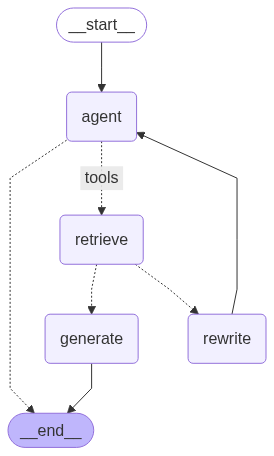

In [25]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

# Add all the nodes to the graph.
workflow.add_node("agent", agent)
workflow.add_node("retrieve", ToolNode(tools))
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# Define the edges and the overall flow.
workflow.add_edge(START, "agent")

# Conditional edge from the agent: either call a tool or end.
workflow.add_conditional_edges(
    "agent",
    lambda state: "tools" if state['messages'][-1].tool_calls else END,
    {"tools": "retrieve", END: END}
)

# Conditional edge from the retrieve node: grade documents.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    # If docs are relevant, generate. If not, rewrite the query and loop back to the agent.
    {"generate": "generate", "rewrite": "rewrite"}
)

# Final edges: after generating an answer, end. After rewriting, go back to the agent.
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile the graph.
graph = workflow.compile()

# Visualize the graph.
graph

### 5. Running the Agentic RAG System

In [26]:
# Invoke the graph with a question about LangGraph.
# The agent should call the correct tool, get relevant docs, and generate an answer.
graph.invoke({"messages": [HumanMessage(content="What is LangGraph?")]})

--- CALL AGENT ---
--- CHECK DOCUMENT RELEVANCE ---
--- DECISION: DOCS RELEVANT ---
--- GENERATE FINAL ANSWER ---


{'messages': [HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, id='7a3546fe-e324-4ad1-8329-ff374ddce4f4'),
  AIMessage(content='I will use the LangGraph search tool to find information about what LangGraph is, since your question is specifically about LangGraph.', additional_kwargs={'tool_calls': [{'id': 'functions.retriever_vector_db_blog:0', 'function': {'arguments': '{"query":"What is LangGraph"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 224, 'total_tokens': 273, 'completion_time': 0.181539955, 'prompt_time': 0.02273794, 'queue_time': 0.284260499, 'total_time': 0.204277895}, 'model_name': 'moonshotai/kimi-k2-instruct', 'system_fingerprint': 'fp_b8565bb333', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--34043c58-1ea6-4689-9ec1-8d52cc61a25c-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 

In [27]:
# Invoke the graph with a question that is NOT about LangChain or LangGraph.
# The agent should answer directly without calling any tools.
graph.invoke({"messages": [HumanMessage(content="What is Machine Learning?")]})

--- CALL AGENT ---


{'messages': [HumanMessage(content='What is Machine Learning?', additional_kwargs={}, response_metadata={}, id='a3ae738b-b70b-4ed6-b05d-3d8686475a5d'),
  AIMessage(content="I don't have access to tools that can provide information about general machine learning concepts. The tools I have available are specifically designed to retrieve information about LangGraph and the LangChain framework, not general topics like machine learning.\n\nMachine learning is a broad field of artificial intelligence that involves training computer algorithms to learn patterns from data and make predictions or decisions without being explicitly programmed for specific tasks. However, for a comprehensive explanation of machine learning concepts, I'd recommend consulting general AI/ML resources, textbooks, or educational websites.\n\nIf you have any questions specifically about LangGraph or LangChain, I'd be happy to help using my specialized search tools!", additional_kwargs={}, response_metadata={'token_usag

### 🔑 Key Takeaways

* **Agentic RAG is Dynamic**: Unlike linear RAG pipelines, Agentic RAG uses an LLM-powered agent to dynamically decide what actions to take, such as choosing the right tool for a given query.
* **Tools are the Agent's Actions**: The core of an Agentic RAG system is giving the agent a set of **tools**. The `create_retriever_tool` function is a simple way to wrap any data retriever into a tool the agent can use.
* **LangGraph for Cyclical Workflows**: LangGraph is the key library for building agentic systems. It allows you to define your workflow as a **state graph** with nodes (actions) and conditional edges (logic), enabling loops and complex decision-making.
* **Self-Correction for Robustness**: This advanced workflow shows a self-corrective pattern. By adding nodes to **grade** the relevance of retrieved documents and **rewrite** the query if needed, the agent can recover from a poor initial retrieval, making the system much more robust.
* **State Management**: The `AgentState` object acts as the agent's memory, persisting information across the different nodes and cycles of the graph.